In [70]:
import random
import numpy as np
import copy
from tabulate import tabulate
from typing import List
from scipy.stats import norm

def sphere(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2)

def weierstrass(x, shift=None, a=0.5, b=3, kmax=20):
    if shift is not None:
        x = x - shift
    D = len(x)
    result = 0
    for i in range(D):
        result += np.sum([a**k * np.cos(2*np.pi*b**k*(x[i]+0.5)) for k in range(kmax)])
    result-=D*np.sum([a**k * np.cos(2*np.pi*b**k*(0.5)) for k in range(kmax)])
    return result

def weierstrass2(x, shift=None, a=0.5, b=3, kmax=20):
    if shift is not None:
        x = x - shift
    D = 25
    result = 0
    for i in range(D):
        result += np.sum([a**k * np.cos(2*np.pi*b**k*(x[i]+0.5)) for k in range(kmax)])
    result-=D*np.sum([a**k * np.cos(2*np.pi*b**k*(0.5)) for k in range(kmax)])
    return result
def rosenbrock(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def schwefel(x, shift=None):
    if shift is not None:
        x = x - shift
    return abs(418.9829*len(x)-np.sum(x * np.sin(np.sqrt(np.abs(x)))))

def griewank(x, shift=None):
    if shift is not None:
        x = x - shift
    part1 = np.sum(x**2)/4000
    part2 = np.prod(np.cos(x/np.sqrt(np.arange(1, len(x)+1))))
    return 1 + part1 - part2

def rastrigin(x, shift=None):
    if shift is not None:
        x = x - shift
    return np.sum(x**2 - 10 * np.cos(2 * np.pi * x) + 10)

def ackley(x, shift=None):
    if shift is not None:
        x = x - shift
    n = len(x)
    return -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / n)) - np.exp(np.sum(np.cos(2 * np.pi * x) / n)) + 20 + np.exp(1)

In [71]:
class SubPopulation:

    def __init__(self, fitness_function, shift_vector, low, high):
        self.fitness_function = fitness_function
        self.shift_vector = shift_vector
        self.limit = [low, high]
        self.generation = [[random.uniform(low, high) for x in range(50)] for y in range(100)]
        self.mean = np.mean(np.array(copy.copy(self.generation)), axis=0)
        self.variance = np.var(np.array(copy.copy(self.generation)), axis=0)
        self.np = np.array(self.generation).T
        self.np = np.append(self.np, [[1 for x in range(len(self.generation))]], axis=0)
    
    def normal_distribution(self, x):
        tmp1 = ((2*np.pi)**(np.pi/2))*(np.sqrt(abs(np.linalg.det(self.covariance))))
        try:
            tmp2 = -1/2*(((x-self.mean).T) @ np.linalg.inv(self.covariance) @ (x-self.mean))
        except Exception:
            cov_matrix = self.covariance
            reg_cov_matrix = cov_matrix + (1e-9) * np.identity(cov_matrix.shape[0])
            tmp2 = -1/2*(((x-self.mean).T) @ np.linalg.inv(reg_cov_matrix) @ (x-self.mean))
            
        return (1/tmp1)*(np.exp(tmp2))

    def fitness(self, x):    
        return self.fitness_function(np.array(x), np.array(self.shift_vector))
    
    def crossover(self, x1, x2, eta_c = 2):
        son1 = copy.deepcopy(x1)
        son2 = copy.deepcopy(x2)
        rmp = random.uniform(0,1)

        if (rmp < 0.2):
            u = random.uniform(0, 1)
            if random.random() < 0.5:
                beta = (2.0 * u)**(1.0 / (eta_c + 1.0))
            else:
                beta = (1.0 / (2.0 * (1.0 - u)))**(1.0 / (eta_c + 1.0))
            
            for k in range(len(x1)):
                son1[k] = 0.5*((1+beta)*x1[k]+(1-beta)*x2[k])
                if son1[k] > self.limit[1]:
                    son1[k] = self.limit[1]
                if son1[k] < self.limit[0]:
                    son1[k] = self.limit[0]

                son2[k] = 0.5*((1-beta)*x1[k]+(1+beta)*x2[k])
                if son2[k] > self.limit[1]:
                    son2[k] = self.limit[1]
                if son2[k] < self.limit[0]:
                    son2[k] = self.limit[0]
        elif (rmp<0.4):
            cross_over_point = random.randint(0, len(x1)-1)
            for k in range(cross_over_point, len(son1)):
                son1[k], son2[k] = son2[k], son1[k]
                
        elif (rmp<0.6):
            mean = copy.deepcopy(self.mean)
            var = copy.deepcopy(self.variance)
            for k in range(len(son1)):
                if norm.pdf(son1[k],  mean[k], np.sqrt(var[k])) < norm.pdf(son2[k],  mean[k], np.sqrt(var[k])):
                    son1[k], son2[k] = son2[k], son1[1]
        
        else:
            for k in range (len(son1)):
                popabiltity = random.uniform(0,1)
                if popabiltity<0.5:
                    tmp1 = son1[k] + random.uniform(0.1,2)*(son2[k]-son1[k])
                    tmp2 = son2[k] + random.uniform(0.1,2)*(son1[k]-son2[k])

                    if(tmp1 > self.limit[1]):
                        son1[k] = self.limit[1]
                    elif (tmp1 < self.limit[0]):
                        son1[k] = self.limit[0]
                    else:
                        son1[k] = tmp1

                    if(tmp2 > self.limit[1]):
                        son2[k] = self.limit[1]
                    elif (tmp2 < self.limit[0]):
                        son2[k] = self.limit[0]
                    else:
                        son2[k] = tmp2
        return son1, son2
    
    def mutation(self, x, eta_m = 5):
        son = copy.deepcopy(x)
        for k in range(len(son)):
            if random.uniform(0,1)<0.1:
                u = random.uniform(0, 1)
                delta = 0
                if u <= 0.5:
                    delta = (2*u)**(1/(eta_m+1)) - 1
                    son[k] = son[k] + delta*(son[k]-self.limit[0])
                else:
                    delta = 1 - (2*(1-u))**(1/(eta_m+1))
                    son[k] = son[k] + delta*(self.limit[1]-son[k])
        return son
        
    def update_population(self, next_generation):
        self.generation += next_generation
        self.generation.sort(key = lambda x: self.fitness(x))
        self.generation = self.generation[0:100]
        self.mean = np.mean(np.array(copy.copy(self.generation)), axis=0)
        self.variance = np.var(np.array(copy.copy(self.generation)), axis=0)
        self.np = np.array(self.generation).T
        self.np = np.append(self.np, [[1 for x in range(len(self.generation))]], axis=0)

    def generate_offspring(self):
        offspring = []
        for parent1 in range(50):
            rmp = random.uniform(0,1)
            if rmp > 0.3:
                parent2 = random.randint(0, len(self.generation)-1)

                son1, son2 = self.crossover(copy.deepcopy(self.generation[parent1]), copy.deepcopy(self.generation[parent2]))
                offspring.append(son1)
                offspring.append(son2)
            else:
                son = self.mutation(copy.deepcopy(self.generation[parent1]))
                offspring.append(son)
       
        return offspring

In [72]:
class Framework:
    def __init__(self,
                fitness_function1, shift_vector1, low1, high1,
                fitness_function2, shift_vector2, low2, high2,
                tranfer_rate = 10
                ) -> None:
        self.task1 = SubPopulation(fitness_function=fitness_function1, shift_vector=shift_vector1, low=low1, high=high1)
        self.task2 = SubPopulation(fitness_function=fitness_function2, shift_vector=shift_vector2, low=low2,  high=high2)
        self.tranfer_rate = tranfer_rate
        self.gen = 0
        self.good = [0, 0]
    
    @property
    def M12(self):
        try:
            matrix_1 = np.linalg.inv(self.task1.np @ self.task1.np.T)
        except Exception:
            matrix_1 = np.linalg.pinv(self.task1.np @ self.task1.np.T)
        
        return matrix_1 @ self.task1.np @ self.task2.np.T
    
    @property
    def M21(self):
        try:
            matrix_1 = np.linalg.inv(self.task2.np @ self.task2.np.T)
        except Exception:
            matrix_1 = np.linalg.pinv(self.task2.np @ self.task2.np.T)
        
        return matrix_1 @ self.task2.np @ self.task1.np.T
            

    def generate_next_generation(self):
        offspring_1 = self.task1.generate_offspring()
        self.task1.update_population(offspring_1)

        offspring_2 = self.task2.generate_offspring()
        self.task2.update_population(offspring_2)

        if (self.gen % self.tranfer_rate == 0):
            tranfer12 = []
            for x in range(0, 10):
                tmp = copy.deepcopy(self.task1.generation[x])
                tmp.append(1)
                tmp = np.array(tmp)@self.M12
                tmp = tmp.tolist()[0:50]
                tranfer12.append(tmp)

            tranfer21 = []
            for x in range(0, 10):
                tmp = copy.deepcopy(self.task2.generation[x])
                tmp.append(1)
                tmp = np.array(tmp)@self.M21
                tmp = tmp.tolist()[0:50]
                tranfer21.append(tmp)
            
            tranfer21.sort(key=lambda x: self.task1.fitness(x))
            tranfer12.sort(key=lambda x: self.task2.fitness(x))

            self.task1.update_population(tranfer21)
            self.task2.update_population(tranfer12)

            if self.task1.fitness(self.task1.generation[10]) >= self.task1.fitness(tranfer21[0]):
                self.good[0]+=1
            if self.task2.fitness(self.task2.generation[10]) >= self.task2.fitness(tranfer12[0]):
                self.good[1]+=1
        self.gen+=1

In [74]:
model1 = Framework(
    griewank, [0 for x in range(25)]+[0 for x in range(25)], -100, 100,
    rastrigin, [0 for x in range(25)]+[0 for x in range(25)], -50, 50
)

model2 = Framework(
    ackley, [0 for x in range(50)], -50, 50,
    rastrigin, [0 for x in range(25)]+[0 for x in range(25)], -50, 50
)

model3 = Framework(
    ackley, [0 for x in range(50)], -50, 50,
    schwefel, [0 for x in range(50)], -500, 500
)

model4 = Framework(
    rastrigin, [0 for x in range(25)]+[0 for x in range(25)], -50, 50,
    sphere, [0 for x in range(50)], 50, 50
)

model5 = Framework(
    ackley, [0 for x in range(50)], -50, 50,
    rosenbrock, [0 for x in range(50)], -50, 50
)

model6 = Framework(
    ackley, [0 for x in range(50)], -50, 50,
    weierstrass2, [0 for x in range(50)], -50, 50
)

history = []
for k in range(1000):
    tmp = []

    model1.generate_next_generation()
    tmp.append(model1.task1.fitness(model1.task1.generation[0]))
    tmp.append(model1.task2.fitness(model1.task2.generation[0]))

    model2.generate_next_generation()
    tmp.append(model2.task1.fitness(model2.task1.generation[0]))
    tmp.append(model2.task2.fitness(model2.task2.generation[0]))

    model3.generate_next_generation()
    tmp.append(model3.task1.fitness(model3.task1.generation[0]))
    tmp.append(model3.task2.fitness(model3.task2.generation[0]))

    model4.generate_next_generation()
    tmp.append(model4.task1.fitness(model4.task1.generation[0]))
    tmp.append(model4.task2.fitness(model4.task2.generation[0]))

    model5.generate_next_generation()
    tmp.append(model5.task1.fitness(model5.task1.generation[0]))
    tmp.append(model5.task2.fitness(model5.task2.generation[0]))


    model6.generate_next_generation()
    tmp.append(model6.task1.fitness(model6.task1.generation[0]))
    tmp.append(model6.task2.fitness(model6.task2.generation[0]))
    history.append(tmp)

c:\Users\DELL\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [75]:
print(model1.good)
print(model2.good)
print(model3.good)
print(model4.good)
print(model5.good)
print(model6.good)

[75, 69]
[30, 81]
[58, 98]
[34, 75]
[89, 100]
[73, 0]


In [94]:
print(model4.task2.generation[0])

[8.98629280682501, 8.986286826791638, 8.98627399078441, 8.986288556312731, 8.98624203335726, 8.986276859491323, 8.986314112210135, 8.986261878075531, 8.986280749090943, 8.986283767718273, 8.986276604915277, 8.986128854910955, 8.986203588332993, 8.985606310543456, 8.985262678226842, 8.985428105872792, 8.986126619193882, 8.986294848270068, 8.986291921206293, 8.986284572949117, 8.986290294592726, 8.986269939771084, 8.98628540165699, 8.986290017518321, 8.986221728208129, 8.986286020886096, 8.986293438799086, 8.98492724535814, 8.98594740939731, 8.985922747551935, 8.986072467787917, 8.986142096632328, 8.82603207105417, 8.98619769045336, 8.986133199388352, 8.986285587925341, 8.98582792236963, 8.986291688705467, 8.986291688705467, 8.986177894073142, 8.986112249888137, 8.98480412901747, 8.9750457143497, 8.986239339748801, 8.985070729791534, 8.986237651998984, 8.985504139301707, 8.986303971588914, 8.986127241475161, 8.986213514372887]


In [95]:
h = []
for k in range(len(history)):
    if k%2==1:
        h.append(history[k])

In [96]:
headers = [f"T{i%2+1}" for i in range(len(h[0]))]
table = tabulate(h, headers=headers, tablefmt='grid')
print(table)

+-------------+----------------+--------------+-----------+--------------+--------------+---------------+-----------+--------------+------------------+--------------+--------------+
|          T1 |             T2 |           T1 |        T2 |           T1 |           T2 |            T1 |        T2 |           T1 |               T2 |           T1 |           T2 |
+=============+================+==============+===========+==============+==============+===============+===========+==============+==================+==============+==============+
| 9.88673     | 9411.29        | 20.6475      | 8556.28   | 20.4808      | 17676.4      | 1195.53       | 125000    | 20.7449      |      4.91046e+08 | 20.4157      | 36.2582      |
+-------------+----------------+--------------+-----------+--------------+--------------+---------------+-----------+--------------+------------------+--------------+--------------+
| 8.25426     | 6391.28        | 20.2184      | 6678.96   | 19.1597      | 12356.3      | 

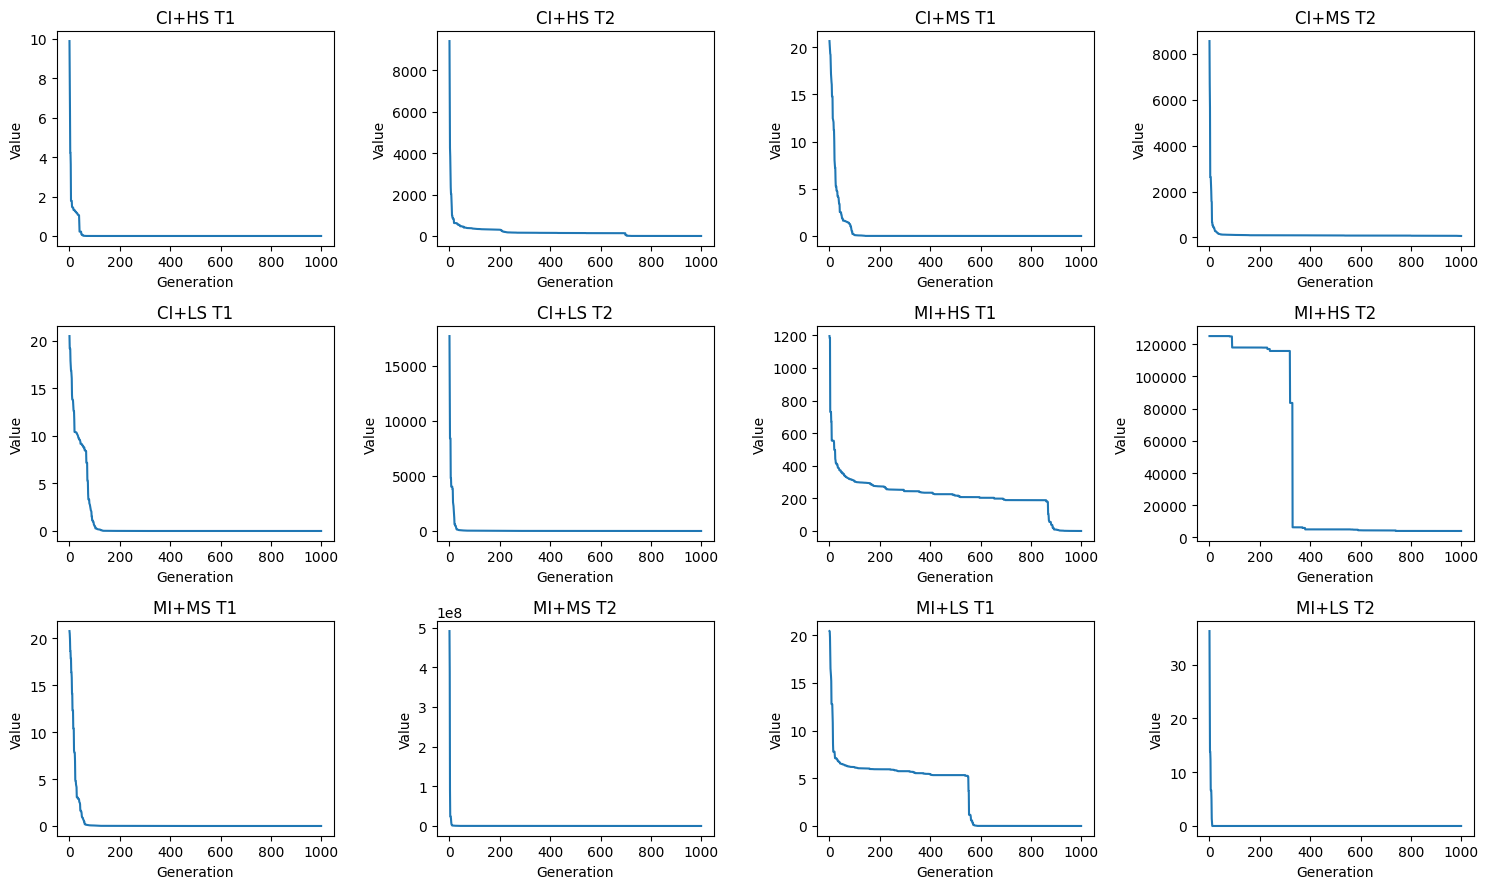

In [91]:
import matplotlib.pyplot as plt

def plot_functions(history):
    num_functions = len(history[0])  # Số lượng hàm
    num_points = len(history)  # Số lượng điểm
    num_plots_per_row = 4  # Số lượng đồ thị trên mỗi hàng

    num_rows = (num_functions + num_plots_per_row - 1) // num_plots_per_row

    # Tạo subplot với kích thước phù hợp
    fig, axs = plt.subplots(num_rows, num_plots_per_row, figsize=(15, num_rows*3))

    for j in range(num_functions):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        if j//2 ==0:
            s = "CI+HS"
        elif j//2==1:
            s = "CI+MS"
        elif j//2 == 2:
            s = "CI+LS"
        elif j//2 == 3:
            s = "MI+HS"
        elif j//2 ==4:
            s = "MI+MS"
        else:
            s = "MI+LS"
    
        axs[row_index, col_index].plot(range(num_points), history[:, j])
        axs[row_index, col_index].set_title(s+f' T{j%2+1}')
        axs[row_index, col_index].set_xlabel('Generation')
        axs[row_index, col_index].set_ylabel('Value')

    # Nếu số lượng hàm không phải là bội số của num_plots_per_row, ẩn các subplot không cần thiết
    for j in range(num_functions, num_rows*num_plots_per_row):
        row_index = j // num_plots_per_row
        col_index = j % num_plots_per_row
        axs[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()


plot_functions(np.array(h))
